In [331]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
os.chdir('C:\\Users\\tyler\\OneDrive\\Documents\\Python\\MLB')

In [332]:
# Load predictions
predictions = pd.read_csv('backend/data/predictions/total_hits.csv')
predictions['date'] = pd.to_datetime(predictions['date'])
predictions = predictions[predictions['date'] != predictions['date'].max()]

In [333]:
# Merge odds
odds = pd.read_excel('backend/data/odds/total_hits.xlsx').dropna(axis=0)
odds['date'] = pd.to_datetime(odds['date'])

df = pd.merge(
    odds,
    predictions,
    left_on=['date', 'visitor', 'home'],
    right_on=['date', 'visitor', 'home'],
    how='left'
)
df['outcome'] = np.where(df['line'] > df['total_hits'], 'u', 'o')

In [334]:
def calc_profit(odds):
    if int(odds) > 0:
        return int(odds) / 100
    else:
        return 100 / abs(int(odds))

In [335]:
models = ['decision_tree', 'gradient_boosted', 'random_forest', 'nn', 'linear_regression']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
# models = ['decision_tree']
# colors = ['red']

In [336]:
# Calculate profit
for model in models:
    df[f'{model}_pick'] = np.where(df['line'] > df[model], 'u', 'o')

    df[f'{model}_potential_profit'] = np.where(
        df[f'{model}_pick'] == 'o', 
        df['over'].apply(calc_profit), 
        df['under'].apply(calc_profit)
    )

    df[f'{model}_profit'] = np.where(
        df[f'{model}_pick'] == df['outcome'],
        df[f'{model}_potential_profit'],
        -1
    )

    df[f'{model}_hit_bust'] = np.where(df[f'{model}_pick'] == df['outcome'], 1, 0)

df = df.dropna(axis=0)

,model,record,accuracy,profit
0,decision_tree,153 - 137,53%,-7.65
4,linear_regression,155 - 135,53%,-9.14
2,random_forest,151 - 139,52%,-13.20
1,gradient_boosted,149 - 141,51%,-21.89
3,nn,146 - 144,50%,-27.52


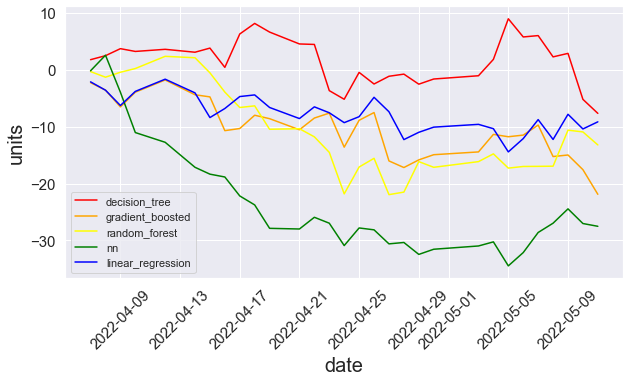

In [337]:
# Graph and print totals
sns.set(rc={"figure.figsize":(10, 5)})
sns.set_palette('bright', 8)
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)

totals = {'model': [], 'record': [], 'accuracy': [], 'profit': []}
for model, col in zip(models, colors):
    # Line graph
    sns.lineplot(
        data=df.groupby(['date']).sum(), 
        x='date', 
        y=df.groupby(['date']).sum()[f'{model}_profit'].cumsum(), 
        color=col, 
        label=model
    )
    
    # Totals
    profit = round(df[f'{model}_profit'].sum(), 2)
    correct = df[f'{model}_hit_bust'].sum()
    wrong = df[f'{model}_hit_bust'].count() - df[f'{model}_hit_bust'].sum()
    
    totals['model'].append(model)
    totals['record'].append(f'{correct} - {wrong}')
    totals['accuracy'].append(f'{round((correct / (correct + wrong) * 100))}%')
    totals['profit'].append(round(profit, 2))
    

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals